# Project 1: Text Processing and Analysis
This notebook processes and analyzes text data from QTL-related research papers. The goal is to extract meaningful terms, visualize patterns, and train models to understand relationships between words.

## Project Breakdown:
1. **Loading Data**: Read the JSON file containing research abstracts.
2. **Data Preprocessing**: Perform text cleaning, tokenization, and stopword removal.
3. **Word Cloud Visualization**: Generate visual representations of word frequency.
4. **Word Embeddings (Word2Vec)**: Train a model to find similar words based on context.
5. **Phrase Extraction and Analysis**: Identify phrases and repeat the previous analyses.
6. **Comparison with Trait Dictionary**: Evaluate how many extracted terms match domain-specific keywords.

## Step 1: Importing Required Libraries
In this step, we import all the necessary libraries required for text processing and analysis:
- `json`: Handles JSON file operations.
- `pandas`: Efficiently manipulates structured tabular data.
- `nltk`: Provides NLP functionalities like tokenization and stopword removal.
- `string`: Helps in processing text by removing unwanted characters.

In [4]:
! pip install wordcloud gensim


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# Import necessary libraries
import json  # Handling JSON data
import pandas as pd  # DataFrame operations
import nltk  # Natural Language Processing toolkit
from nltk.tokenize import sent_tokenize, word_tokenize  # Sentence and word tokenization
from nltk.corpus import stopwords  # Stopword list to remove unimportant words
import string  # String processing utilities

## Step 2: Downloading NLTK Resources
Since NLTK requires additional resources like tokenizers and stopwords, we must download them before use:
- `punkt`: Used for sentence and word tokenization.
- `stopwords`: Contains common words (e.g., 'the', 'is') that we will remove.

In [7]:
# Download necessary NLTK resources for text processing
nltk.download('punkt')  # Enables sentence and word tokenization
nltk.download('stopwords')  # Provides a list of common stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kosht\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kosht\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Step 3: Loading and Filtering the Dataset
The dataset is stored in `QTL_text.json`. Each entry contains:
- `PMID`: The paper's unique identifier.
- `Journal`: The journal where it was published.
- `Title`: The title of the research paper.
- `Abstract`: The main body of text containing research findings.
- `Category`: Label indicating if the paper is relevant (1) or irrelevant (0).

**What happens in this step?**
1. Load the JSON file and store it in a Pandas DataFrame.
2. Keep only the relevant columns
3. Filter out irrelevant papers (`Category = 0`).
4. Display the first few rows of the filtered dataset.

In [9]:
# Load QTL_text.json file and convert it into a DataFrame
with open('QTL_text.json', 'r') as file:
    data = json.load(file)

# Convert JSON data into a Pandas DataFrame
df = pd.DataFrame(data)

# Display the columns in our dataframe
df.columns

Index(['PMID', 'Journal', 'Title', 'Abstract', 'Category'], dtype='object')

In [10]:
# Keep only the relevant columns for further analysis
df = df[['Abstract', 'Category']]
df.head()

,Abstract,Category
0,"In a previous study, QTL for carcass compositi...",1
1,Pituitary adenylate cyclase-activating polypep...,0
2,Clinical and parasitological traits of Sarcocy...,0
3,A whole-genome quantitative trait locus (QTL) ...,1
4,Fatty acid bing protein 4 (FABP4) plays a key ...,0


In [11]:
# Keep only relevant research papers (Category = 1)
df = df[df['Category'] == '1']
df.head()

,Abstract,Category
0,"In a previous study, QTL for carcass compositi...",1
3,A whole-genome quantitative trait locus (QTL) ...,1
5,A partial genome scan using microsatellite mar...,1
7,BACKGROUND: The rate of pubertal development a...,1
10,"Previously, quantitative trait loci (QTL) for ...",1


## Step 4: Text Preprocessing
To prepare the text for analysis, we perform the following steps:
- **Sentence Tokenization**: Splitting abstracts into individual sentences.
- **Word Tokenization**: Splitting each sentence into words.
- **Lowercasing**: Converting all words to lowercase to maintain consistency.
- **Removing Non-Alphabetic Words**: Eliminating numbers and special characters.
- **Stopword Removal**: Filtering out common English words to focus on meaningful terms.

A custom function `preprocess_text()` is defined to automate these steps.

In [13]:
# Define a function to preprocess text
def preprocess_text(text):
    sentences = sent_tokenize(text)  # Split into sentences
    words = [word_tokenize(sent) for sent in sentences]  # Tokenize each sentence into words
    words = [w.lower() for sent in words for w in sent]  # Convert to lowercase
    words = [w for w in words if w.isalpha()]  # Remove punctuation and numbers
    stop_words = set(stopwords.words('english'))  # Load common stopwords
    words = [w for w in words if w not in stop_words]  # Remove stopwords
    return words

## Step 5: Applying Preprocessing to Abstracts
Now that we have a function to clean the text, we apply it to all abstracts in the dataset.

**What happens in this step?**
1. Apply the `preprocess_text()` function to each abstract.
2. Store the processed abstracts in a new column (`Processed_Abstract`).
3. Display the first few processed abstracts to verify the transformation.

In [15]:
# Apply the text preprocessing function to all abstracts
df['Processed_Abstract'] = df['Abstract'].apply(preprocess_text)

# Display the first few processed abstracts
df.head()

,Abstract,Category,Processed_Abstract
0,"In a previous study, QTL for carcass compositi...",1,"[previous, study, qtl, carcass, composition, m..."
3,A whole-genome quantitative trait locus (QTL) ...,1,"[quantitative, trait, locus, qtl, scan, phenot..."
5,A partial genome scan using microsatellite mar...,1,"[partial, genome, scan, using, microsatellite,..."
7,BACKGROUND: The rate of pubertal development a...,1,"[background, rate, pubertal, development, wean..."
10,"Previously, quantitative trait loci (QTL) for ...",1,"[previously, quantitative, trait, loci, qtl, b..."


## Step 6: Generating Word Cloud Visualizations
Word clouds are used to visualize the most common words in the corpus. Two types of word clouds are generated:
- **Word Frequency-Based Word Cloud**: Displays words based on their occurrence count.
- **TF-IDF-Based Word Cloud**: Gives higher importance to words that appear frequently in some abstracts but not across all.

**What happens in this step?**
1. The processed text is aggregated into a single document.
2. Word frequency is calculated.
3. A word cloud image is generated and saved.
4. The same process is repeated using TF-IDF scores to highlight significant words.

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
# Flatten processed words into a single string for word frequency visualization
all_words = " ".join([" ".join(words) for words in df["Processed_Abstract"]])

# Generate Word Cloud using Word Frequency
wordcloud_freq = WordCloud(width=800, height=800, background_color="white").generate(all_words)

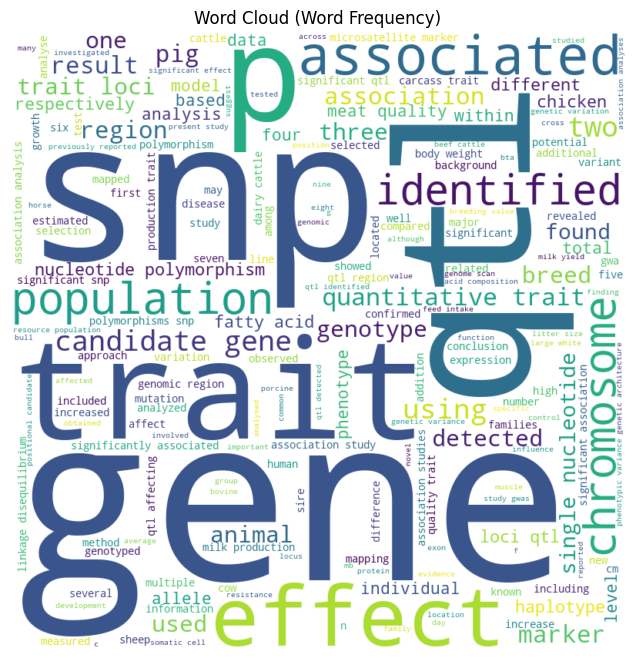

In [19]:
# Plot Word Cloud (Word Frequency)
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_freq, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud (Word Frequency)")
plt.show()

In [20]:
# Generate Word Cloud using TF-IDF

# Convert processed abstracts back to text format
text_data = [" ".join(words) for words in df["Processed_Abstract"]]

# Apply TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Limiting features to top 100 for visualization
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

# Get words with highest TF-IDF scores
tfidf_scores = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix.sum(axis=0).A1))

# Generate Word Cloud using TF-IDF scores
wordcloud_tfidf = WordCloud(width=800, height=800, background_color="white").generate_from_frequencies(tfidf_scores)

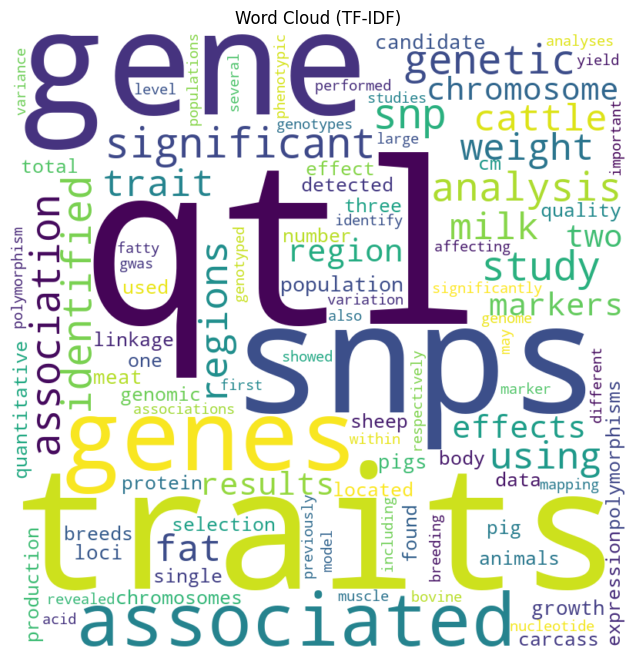

In [21]:
# Plot Word Cloud (TF-IDF)
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_tfidf, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud (TF-IDF)")
plt.show()

## Step 7: Training a Word2Vec Model
Word2Vec is a neural network-based model that learns word relationships by analyzing how words appear in similar contexts.

**Model Parameters:**
- `vector_size=100`: Each word is represented as a 100-dimensional vector.
- `window=5`: Considers a context window of 5 words around each word.
- `min_count=10`: Ignores words that appear less than 10 times.

**What happens in this step?**
1. The cleaned text is tokenized into individual words.
2. A Word2Vec model is trained on the corpus.
3. The model learns to associate words that appear in similar contexts.
4. For each of the **top 10 TF-IDF words**, the 20 most similar words are retrieved and displayed.

In [23]:
from gensim.models import Word2Vec

In [24]:
# Prepare data for Word2Vec (list of tokenized sentences)
sentences = df["Processed_Abstract"].tolist()

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=10, workers=4)

# Save the model (optional, for reuse)
word2vec_model.save("word2vec_qtl.model")

# Print model summary
print("Word2Vec model trained successfully!")
print(f"Vocabulary size: {len(word2vec_model.wv)}")

Word2Vec model trained successfully!
Vocabulary size: 1866


In [25]:
# Extract top 10 words from TF-IDF
top_10_words = sorted(tfidf_scores, key=tfidf_scores.get, reverse=True)[:10]

# Print the 20 most similar words for each top TF-IDF word
print("\nMost Similar Words for Top 10 TF-IDF Words:\n")
for word in top_10_words:
    if word in word2vec_model.wv:
        similar_words = word2vec_model.wv.most_similar(word, topn=20)
        print(f"\nWord: {word}")
        i=1
        for sim_word, score in similar_words:
            print(f" {i}  {sim_word} ({score:.2f})")
            i += 1
    else:
        print(f"\nWord: {word} - Not found in vocabulary")


Most Similar Words for Top 10 TF-IDF Words:


Word: qtl
 1  qtls (0.97)
 2  mapped (0.94)
 3  locus (0.94)
 4  chromosome (0.93)
 5  previously (0.92)
 6  detected (0.90)
 7  chromosomes (0.90)
 8  regions (0.89)
 9  reported (0.88)
 10  suggestive (0.87)
 11  identified (0.86)
 12  chromosomal (0.86)
 13  several (0.85)
 14  putative (0.84)
 15  pleiotropic (0.84)
 16  trait (0.83)
 17  significance (0.83)
 18  loci (0.83)
 19  one (0.83)
 20  harbouring (0.83)

Word: traits
 1  meat (0.95)
 2  growth (0.94)
 3  quality (0.93)
 4  production (0.91)
 5  carcass (0.91)
 6  important (0.90)
 7  economically (0.89)
 8  fatness (0.88)
 9  related (0.87)
 10  bone (0.85)
 11  beef (0.85)
 12  eggshell (0.85)
 13  technological (0.84)
 14  fertility (0.83)
 15  affect (0.83)
 16  deposition (0.83)
 17  composition (0.82)
 18  efficiency (0.81)
 19  pork (0.80)
 20  affecting (0.80)

Word: snps
 1  associations (0.97)
 2  snp (0.95)
 3  intron (0.92)
 4  exon (0.92)
 5  g (0.90)
 6  showed (

## Step 8: Extracting Phrases
Phrases are multi-word expressions that carry significant meaning, such as 'gene mutation' or 'protein expression'.

**What happens in this step?**
1. A phrase detection method is applied to extract meaningful multi-word terms.
2. These phrases are analyzed for frequency and importance.
3. The word cloud and Word2Vec analyses are repeated on extracted phrases.
4. The results are compared to single-word analysis to assess improvements.

In [ ]:
from gensim.models.phrases import Phrases, Phraser

# Prepare data for phrase extraction (list of tokenized abstracts)
sentences = df["Processed_Abstract"].tolist()

# Train bigram and trigram models
bigram = Phrases(sentences, min_count=5, threshold=10)  # Adjust min_count & threshold as needed
trigram = Phrases(bigram[sentences], threshold=10)

# Convert Phrases to efficient Phraser objects
bigram_phraser = Phraser(bigram)
trigram_phraser = Phraser(trigram)

# Apply phrase models to sentences
df["Processed_Abstract_Bigrams"] = df["Processed_Abstract"].apply(lambda x: bigram_phraser[x])
df["Processed_Abstract_Trigrams"] = df["Processed_Abstract_Bigrams"].apply(lambda x: trigram_phraser[x])

# Display sample bigrams and trigrams
df.head()

In [ ]:
# Convert bigrams/trigrams into single text strings for WordCloud
all_words_phrases = " ".join([" ".join(words) for words in df["Processed_Abstract_Trigrams"]])

# Generate Word Cloud for Phrases (Word Frequency)
wordcloud_freq_phrases = WordCloud(width=800, height=800, background_color="white").generate(all_words_phrases)

# Plot Word Cloud (Word Frequency - Phrases)
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_freq_phrases, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud (Word Frequency - Phrases)")
plt.show()

In [ ]:
# Generate Word Cloud using TF-IDF for Phrases

# Convert processed phrases back to text format
text_data_phrases = [" ".join(words) for words in df["Processed_Abstract_Trigrams"]]

# Apply TF-IDF vectorization
tfidf_vectorizer_phrases = TfidfVectorizer(max_features=100)  # Limiting features to top 100 for visualization
tfidf_matrix_phrases = tfidf_vectorizer_phrases.fit_transform(text_data_phrases)

# Get words with highest TF-IDF scores
tfidf_scores_phrases = dict(zip(tfidf_vectorizer_phrases.get_feature_names_out(), tfidf_matrix_phrases.sum(axis=0).A1))

# Generate Word Cloud using TF-IDF scores
wordcloud_tfidf_phrases = WordCloud(width=800, height=800, background_color="white").generate_from_frequencies(tfidf_scores_phrases)

# Plot Word Cloud (TF-IDF - Phrases)
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_tfidf_phrases, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud (TF-IDF - Phrases)")
plt.show()

In [ ]:
# Train Word2Vec model on extracted phrases
word2vec_phrases_model = Word2Vec(df["Processed_Abstract_Trigrams"].tolist(), vector_size=100, window=5, min_count=10, workers=4)

# Save the model (optional)
word2vec_phrases_model.save("word2vec_phrases_qtl.model")

# Print vocabulary size
print("Word2Vec model trained on phrases!")
print(f"Vocabulary size (phrases): {len(word2vec_phrases_model.wv)}")


In [ ]:
# Train Word2Vec model on extracted phrases
word2vec_phrases_model = Word2Vec(df["Processed_Abstract_Trigrams"].tolist(), vector_size=100, window=5, min_count=10, workers=4)

# Save the model (optional)
word2vec_phrases_model.save("word2vec_phrases_qtl.model")

# Print vocabulary size
print("Word2Vec model trained on phrases!")
print(f"Vocabulary size (phrases): {len(word2vec_phrases_model.wv)}")


## Step 9: Comparing Extracted Phrases with the Trait Dictionary
The extracted phrases are compared with `Trait dictionary.txt`, a predefined list of domain-specific terms.

**What happens in this step?**
1. The extracted phrases are stored in a list.
2. Each phrase is checked against the terms in `Trait dictionary.txt` using exact string matching.
3. The percentage of matched terms is calculated to evaluate the relevance of extracted phrases.
4. Insights are drawn based on the proportion of meaningful matches.

In [ ]:
from difflib import get_close_matches

trait_dict_path = 'Trait dictionary.txt'

with open(trait_dict_path, "r", encoding="utf-8") as file:
    trait_terms = set(line.strip().lower().replace("_", " ") for line in file if line.strip())  # Normalize terms

# Function to compare extracted phrases with the trait dictionary using substring and word matching
def match_phrases_with_trait_dict_advanced(extracted_phrases, trait_terms):
    extracted_phrases = [phrase.strip().lower().replace("_", " ") for phrase in extracted_phrases]  # Normalize phrases
    matched_phrases = {}

    for phrase in extracted_phrases:
        words = phrase.split()  # Split phrase into words
        for term in trait_terms:
            # Check if entire phrase or any individual word matches a trait dictionary term
            if phrase in term or any(word in term for word in words):
                matched_phrases[phrase] = term
                break  # Stop checking after first match

    match_count = len(matched_phrases)
    total_phrases = len(extracted_phrases)

    return match_count, total_phrases, matched_phrases

In [ ]:
extracted_phrases = ["gene expression", "protein structure", "animal trait", "dna sequence"]  # Example extracted phrases

# Run the improved matching function
match_count, total_phrases, matched_phrases = match_phrases_with_trait_dict_advanced(extracted_phrases, trait_terms)

# Display results
match_percentage = (match_count / total_phrases) * 100 if total_phrases > 0 else 0

print("\nFinal Matching Results:")
print(f"Total Extracted Phrases: {total_phrases}")
print(f"Matched Phrases Count: {match_count}")
print(f"Matched Phrases: {matched_phrases}")
print(f"Match Percentage: {match_percentage:.2f}%")